# How Has Scholarship on China Changed?

Description: 

This project came about due to my research interests in China and being interested in what position China has played in the development of the academic study of religion. So, I thought that if I wanted to be able to answer that question, I would need data from a source that was well established in the field. At that point, I knew that the Journal of Religion had been around since the 1880s, and Jstor has the Data for Research opition, so I thought why not pull data from Jstor specifically from the Journal of Religion that deals with China. Well, jstor only gave me data from 1921-2015, I assume this is due to copyright laws, but I not hundred percent sure on that. And, the data that Jstor gave me 664 xml files and ngrams. So, my first task was to figure out what I could do with this data. This file before you is after the fact--I'm pulling in everything that I done, into hopefully one nice and clean jupyter notebook. 

In [7]:
#Import everything
# !pip install lda
from bs4 import BeautifulSoup
import lxml
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import glob
import re
import json
import csv
import lda 
import nltk
from nltk.corpus import stopwords
import collections
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from nltk import FreqDist
import spacy
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from stop_words import get_stop_words
import matplotlib.pyplot as plt

In [2]:
#Let's take the XML data and turn it into something that is usable
def extract_xml_data(xml_content, data_field_list):
    data_from_article = {}
    for field in data_field_list:
        #print(field)
        
       
        try:
            content = soup.find(field).get_text()
            data_from_article[field] = content
        except:
            data_from_article[field] = 'Article' 
            
    return data_from_article


In [3]:
xml_files = os.listdir('Metadata')

In [4]:
all_data = {}
fields = ['given-names', 'surname', 'article-title', 'month', 'year', 'subject']

for each in xml_files:
    with open('Metadata/{}'.format(each), 'r') as f:
        ugly_xml = f.read()
    
    soup = BeautifulSoup(ugly_xml, 'xml')
    
    subject_value = soup.find('subject')
#     print(subject_value)
    
    all_data[each] = extract_xml_data(ugly_xml, fields)
    
#Now we can use the xml data to create a dataframe

## What Type and Quantity of Scholarship on China was the Journal of Religion Publishing? 

In [5]:
df_1 = pd.DataFrame.from_dict(all_data, orient='index')
df_1['date_time'] = pd.to_datetime(df_1['year'], format='%Y')

In [6]:
counts_df = df_1.groupby(['date_time', 'subject'], as_index=False)['article-title'].count()
counts_df = counts_df.rename(columns={'article-title': "counts"})

In [7]:
df_grouped = df_1.groupby(['date_time', 'subject'], dropna=False)['article-title'].count().to_frame()
df_grouped.reset_index(inplace=True)
df_grouped = df_grouped.rename(columns = {'article-title': 'article-count'})
# df_grouped
df_wide = df_grouped.pivot(columns = 'subject', index='date_time', values='article-count')
df_wide.index.name = None

In [8]:
fig = go.Figure()

fig.add_trace(go.Bar(x = counts_df['date_time'], y=counts_df['counts'], visible=True))

fig.update_layout(xaxis_tickangle=-45)

buttons = []
buttons.append(dict(method='restyle',
                        label='All',
                        visible=True,
                        args=[{'y':[counts_df['counts']],
                               'x':[counts_df['date_time']],
                               'type':'bar'}, [0]],
                        )
                  )
# button with one option for each dataframe
for col in df_wide.columns:
    buttons.append(dict(method='restyle',
                        label=col,
                        visible=True,
                        args=[{'y':[df_wide[col]],
                               'x':[df_wide.index],
                               'type':'bar'}, [0]],
                        )
                  )

# Create the menu
updatemenu = []

your_menu = dict()
updatemenu.append(your_menu)

updatemenu[0]['buttons'] = buttons
updatemenu[0]['direction'] = 'down'
updatemenu[0]['showactive'] = True

# print(updatemenu)

fig.update_layout(showlegend=False, updatemenus=updatemenu)

fig.show()



Description:

What intriques me here is that no type of scholarship with 'China' is being published from this journal in 1973 & 1974. While the main concentration of Scholarship takes place in the 1920s, with 1922 having the most publications at 27 with 25 being articles. So, my question, that I am unable to answer currently, is what is going on at this time for an increase interest in China? 

# If people are publishing about China, what is China in relation to? 
### What is most common word over time? 

In [9]:
# I had to delete one file from both Metadata and word-count file due to the ngram1 file not containing any information. This was the file that I had to deletejournal-article-10.2307_1196540-ngram1.txt
#I found this awesome code, that stitches together the pub-year from the xml to the ngrams1! Here is the link https://github.com/sethsch/python-jstor-dfr

total_freq = {}

# The json schema here is {pub-year: {word: count}}

for xml in glob.iglob('Metadata/*.xml'):
    with open(xml) as f:
        bs = BeautifulSoup(f, "lxml-xml")
    
    # Extract pub lish year
    pub_year = bs.year
    year = int(str(pub_year)[6:10])
    
    total_freq[year] = total_freq.get(year, {})

    
    txt = xml.replace("Metadata", "word-count").replace(".xml", "-ngram1.txt")
    
    
    
    with open(txt) as t:
        for line in t:
            sub = re.split("\s+", line)
            word = sub[0]
            count = int(sub[1])
            
            if total_freq[year].get(word, 0) == 0:
                total_freq[year][word] = 0

            total_freq[year][word] += count

    
file = open("count.json", "w")
    
with file:
    json.dump(total_freq, file)

In [10]:
#Let's create our second dataframe
df_2 = pd.DataFrame.from_dict(total_freq, orient = 'index')

In [11]:
long_df = pd.melt(df_2, ignore_index = False)

/ext/anaconda2020.02/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning:

This dataframe has a column name that matches the 'value_name' column name of the resultiing Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.



In [12]:
long_df.reset_index(inplace=True)

In [13]:
#I tried creating a loop for removing stop words from the data frame but it pulled out the variable column, so I guess I'm doing this probably the worst way

long_df.drop(long_df.index[long_df['variable'] == 's'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == '00'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == '95'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == '0'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == '1'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'i'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'pp'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'has'], inplace = True)

In [14]:
long_df.drop(long_df.index[long_df['variable'] == 'new'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'which'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'from'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'his'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'its'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'have'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'all'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'he'], inplace = True)

In [15]:
long_df.drop(long_df.index[long_df['variable'] == 'one'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'been'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'pages'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'we'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'would'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'had'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'j'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'our'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'cloth'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'hardback'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'you'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'p'], inplace = True)

In [16]:
long_df.drop(long_df.index[long_df['variable'] == 'new'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'york'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'press'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'were'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'any'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'isbn'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == '35'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == '800'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == '86554'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'ii'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'e'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'd'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'her'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'b'], inplace = True)

In [17]:
long_df.drop(long_df.index[long_df['variable'] == 'who'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'also'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'what'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'more'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'may'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'should'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'those'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'ibid'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == '86554'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'h'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == '6'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == '50'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == '3'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'car'], inplace = True)

In [18]:
long_df.drop(long_df.index[long_df['variable'] == 'same'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'l'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'see'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'my'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'so'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'between'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'other'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'us'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'she'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'many'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'work'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'can'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'your'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == '2'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == '4'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == '75'], inplace = True)

In [19]:
long_df.drop(long_df.index[long_df['variable'] == 'only'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'them'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'than'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'factor'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == '5'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'co'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'two'], inplace = True)

In [20]:
long_df.drop(long_df.index[long_df['variable'] == 'most'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'must'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'upon'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'me'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'do'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'cannot'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'when'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'some'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'through'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'people'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'much'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'w'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'm'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'person'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'does'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'him'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'st'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'm'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'yet'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'c'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'x'], inplace = True)

In [21]:
long_df.drop(long_df.index[long_df['variable'] == 'could'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'd'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'when'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'how'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'whether'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'yet'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'out'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'even'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'type'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'action'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'well'], inplace = True)

In [22]:
long_df.drop(long_df.index[long_df['variable'] == 'very'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'mr'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'dr'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'made'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'own'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'far'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'himself'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == '25'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == '7'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'now'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'each'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'like'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'here'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'about'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'within'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'n'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 't'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'both'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'r'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'n'], inplace = True)

In [23]:
long_df.drop(long_df.index[long_df['variable'] == 'thus'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'itself'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'still'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'make'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'sense'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'focus'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'never'], inplace = True)
long_df.drop(long_df.index[long_df['variable'] == 'while'], inplace = True)

In [24]:
pd.set_option('display.max_row', 2000)

top_ten_words = long_df.groupby('index').apply(lambda x : x.sort_values(by = 'value', ascending = False).head(10).reset_index(drop = True))
top_fifteen_words = long_df.groupby('index').apply(lambda x : x.sort_values(by = 'value', ascending = False).head(15).reset_index(drop = True))

### Top Ten Words Over Time

In [25]:
top_ten_words

index        variable  value
index                                
1921  0   1921        religion  374.0
      1   1921       religious  244.0
      2   1921            life  188.0
      3   1921      university  173.0
      4   1921         chicago  168.0
      5   1921         journal  150.0
      6   1921             god  130.0
      7   1921       professor  130.0
      8   1921           world  122.0
      9   1921       christian  119.0
1922  0   1922        religion  460.0
      1   1922          church  312.0
      2   1922       religious  279.0
      3   1922       christian  249.0
      4   1922         chicago  246.0
      5   1922           china  237.0
      6   1922      university  232.0
      7   1922            life  193.0
      8   1922          social  182.0
      9   1922           world  172.0
1923  0   1923        religion  378.0
      1   1923       religious  227.0
      2   1923            life  207.0
      3   1923         chicago  183.0
      4   1923      university  178.0
      5   1923       christian  167.0
      6   1923           china  139.0
      7   1923           world  139.0
      8   1923          church  138.0
      9   1923            book  132.0
1924  0   1924        religion  329.0
      1   1924       religious  208.0
      2   1924         chicago  178.0
      3   1924           world  175.0
      4   1924      university  164.0
      5   1924       christian  162.0
      6   1924            life  155.0
      7   1924          church  155.0
      8   1924        students  112.0
      9   1924            book  101.0
1925  0   1925       religious  318.0
      1   1925        religion  314.0
      2   1925       christian  220.0
      3   1925           world  214.0
      4   1925         chicago  199.0
      5   1925            life  194.0
      6   1925      university  190.0
      7   1925           china  179.0
      8   1925          church  174.0
      9   1925            book  155.0
1926  0   1926        religion  330.0
      1   1926         chicago  209.0
      2   1926          church  195.0
      3   1926       religious  191.0
      4   1926      university  184.0
      5   1926       christian  175.0
      6   1926           world  170.0
      7   1926            book  141.0
      8   1926            life  136.0
      9   1926         history  132.0
1927  0   1927        religion  464.0
      1   1927            life  232.0
      2   1927       religious  208.0
      3   1927         chicago  198.0
      4   1927      university  184.0
      5   1927             man  154.0
      6   1927           world  148.0
      7   1927          shinto  117.0
      8   1927          modern  107.0
      9   1927           great  101.0
1928  0   1928        religion  384.0
      1   1928       religious  202.0
      2   1928            1927  196.0
      3   1928          church  165.0
      4   1928      university  162.0
      5   1928         chicago  161.0
      6   1928       christian  144.0
      7   1928            life  135.0
      8   1928            book   99.0
      9   1928         journal   88.0
1929  0   1929        religion  174.0
      1   1929         chicago  150.0
      2   1929       christian  132.0
      3   1929      university  129.0
      4   1929            book  124.0
      5   1929          church  124.0
      6   1929       religious  107.0
      7   1929           jesus   99.0
      8   1929            1928   95.0
      9   1929          christ   80.0
1930  0   1930        religion  185.0
      1   1930       christian  147.0
      2   1930             war  115.0
      3   1930          church  107.0
      4   1930           world   87.0
      5   1930            book   70.0
      6   1930       religious   68.0
      7   1930           peace   68.0
      8   1930    christianity   65.0
      9   1930            1929   60.0
1931  0   1931        religion  157.0
      1   1931          social  121.0
      2   1931       religious  108.0
      3   1931     

### Top Fifteen Words Over Time

In [27]:
top_fifteen_words

index        variable  value
index                                 
1921  0    1921        religion  374.0
      1    1921       religious  244.0
      2    1921            life  188.0
      3    1921      university  173.0
      4    1921         chicago  168.0
      5    1921         journal  150.0
      6    1921             god  130.0
      7    1921       professor  130.0
      8    1921           world  122.0
      9    1921       christian  119.0
      10   1921          social  115.0
      11   1921           china  100.0
      12   1921          modern   96.0
      13   1921       education   95.0
      14   1921         friends   94.0
1922  0    1922        religion  460.0
      1    1922          church  312.0
      2    1922       religious  279.0
      3    1922       christian  249.0
      4    1922         chicago  246.0
      5    1922           china  237.0
      6    1922      university  232.0
      7    1922            life  193.0
      8    1922          social  182.0
      9    1922           world  172.0
      10   1922    christianity  155.0
      11   1922            book  150.0
      12   1922         journal  145.0
      13   1922           bible  144.0
      14   1922       professor  138.0
1923  0    1923        religion  378.0
      1    1923       religious  227.0
      2    1923            life  207.0
      3    1923         chicago  183.0
      4    1923      university  178.0
      5    1923       christian  167.0
      6    1923           china  139.0
      7    1923           world  139.0
      8    1923          church  138.0
      9    1923            book  132.0
      10   1923             god  127.0
      11   1923         article  115.0
      12   1923        buddhism  114.0
      13   1923           great  110.0
      14   1923          social  107.0
1924  0    1924        religion  329.0
      1    1924       religious  208.0
      2    1924         chicago  178.0
      3    1924           world  175.0
      4    1924      university  164.0
      5    1924       christian  162.0
      6    1924            life  155.0
      7    1924          church  155.0
      8    1924        students  112.0
      9    1924            book  101.0
      10   1924             god   98.0
      11   1924         journal   97.0
      12   1924       education   97.0
      13   1924          social   94.0
      14   1924         student   93.0
1925  0    1925       religious  318.0
      1    1925        religion  314.0
      2    1925       christian  220.0
      3    1925           world  214.0
      4    1925         chicago  199.0
      5    1925            life  194.0
      6    1925      university  190.0
      7    1925           china  179.0
      8    1925          church  174.0
      9    1925            book  155.0
      10   1925       education  147.0
      11   1925          modern  126.0
      12   1925            1924  126.0
      13   1925          social  121.0
      14   1925             god  113.0
1926  0    1926        religion  330.0
      1    1926         chicago  209.0
      2    1926          church  195.0
      3    1926       religious  191.0
      4    1926      university  184.0
      5    1926       christian  175.0
      6    1926           world  170.0
      7    1926            book  141.0
      8    1926            life  136.0
      9    1926         history  132.0
      10   1926           study  129.0
      11   1926        postpaid  118.0
      12   1926       religions  106.0
      13   1926         journal   97.0
      14   1926          modern   95.0
1927  0    1927        religion  464.0
      1    1927            life  232.0
      2    1927       religious  208.0
      3    1927         chicago  198.0
      4    1927      university  184.0
      5    1927             man  154.0
      6    1927           world  148.0
      7    1927          shinto  117.0
      8    1927          modern  107.0
      9    1927           great  101.0
      10   1927          social 

Description:

So, it seems that earliery on you will find "Christian," "Christianity,"and "Church" in the top ten and top fifteen words. Which helps confirm some of my suspicions that people are only interested in China early on for the purpose of Missionary work. But without the ability to do a close reading of the documents, I can't confirm this. Because, Jstor doesn't give you that type of data. 

Now, at this point in this project, I wasn't sure what to do, because a part of this assignment was to do three different analysis techniques, and I couldn't figure out how to do a different analysis with the data that Jstor gave me. Now, I'm not saying you couldn't, I'm saying that I wasn't sure what I could. Plus, I spent several hours trying to things, so I was done with this data. And, I thought to myself, well why don't you use an older text so that you can look at how scholars/authors are representing China. So, I was going to use Russell Betrand's The Problem of China, because it was published in the year 1922, but I guess either the text file is too large or I don't have enough memory, because the word count function basically broke trying to run using that document. So, I decided to use the book An Australian in China by George Ernest Morrison, originally published by 1895. 

# Representations of China in An Australian in China

### What are the most common words?
### What are the topics of this book? 
### Is China being portrayed negatively or postively?

In [2]:
#Load in the text

text_file = "texts-on-china/19172.txt"

with open(text_file, 'r') as f:
    content = f.read()

In [3]:
wordlist = content.split()

In [4]:
wordfreq = []

In [5]:
for word in wordlist:
    wordfreq.append(wordlist.count(word))

In [6]:
word_dictionary = dict(zip(wordlist, wordfreq))

In [8]:
word_dictionary.items()

dict_items([('Project', 78), ("Gutenberg's", 2), ('An', 29), ('Australian', 5), ('in', 2165), ('China,', 104), ('by', 632), ('George', 5), ('Ernest', 3), ('Morrison', 3), ('This', 49), ('eBook', 5), ('is', 1113), ('for', 620), ('the', 6458), ('use', 30), ('of', 3507), ('anyone', 10), ('anywhere', 3), ('at', 425), ('no', 203), ('cost', 21), ('and', 2450), ('with', 944), ('almost', 43), ('restrictions', 2), ('whatsoever.', 3), ('You', 17), ('may', 65), ('copy', 8), ('it,', 38), ('give', 33), ('it', 389), ('away', 36), ('or', 266), ('re-use', 2), ('under', 122), ('terms', 28), ('Gutenberg', 19), ('License', 8), ('included', 4), ('this', 283), ('online', 4), ('www.gutenberg.org', 2), ('Title:', 1), ('China', 171), ('Being', 1), ('Narrative', 1), ('a', 1991), ('Quiet', 1), ('Journey', 1), ('Across', 1), ('to', 2151), ('Burma', 30), ('Author:', 1), ('Release', 1), ('Date:', 1), ('September', 2), ('4,', 3), ('2006', 1), ('[EBook', 1), ('#19172]', 1), ('Language:', 1), ('English', 37), ('Chara

In [9]:
sorted_dictionary = sorted(word_dictionary.items(), key=lambda x: x[1], reverse=True)

In [10]:
#function that counts words
def count_words(textblock):
    wordlist = textblock.split()
    wordfreq = []
    for word in wordlist:
        wordfreq.append(wordlist.count(word))
    word_dictionary = dict(zip(wordlist, wordfreq))
    sorted_dictionary = sorted(word_dictionary.items(), key=lambda x: x[1], reverse=True)
    
    return (sorted_dictionary)

In [11]:
no_punct = re.sub(r'[^\w\s]', '', content)

In [12]:
cleaned_text = re.sub(r'[_]', '', no_punct)

In [13]:
#Let's customize the stopwords
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['project','gutenbergs', 'gutenberg','wwwgutenbergorg','httpwwwpgdpnet', 'ebook', 'online','anyone','anywhere','use','terms', 'httpwwwgutenbergorg', 'one','two','three','many','every','way','day','would','could','years','days','us','may','among','came','page','well','left','upon','said','never','mr','even','made','see','cited','like','seen','gutenbergtm','yet','must','still','whose']
stopwords.extend(newStopWords)

In [14]:
filtered_content = []

for word in cleaned_text.lower().split():
    if word not in stopwords:
        filtered_content.append(word)
    else:
        pass

In [15]:
df_3 = pd.DataFrame.from_dict(count_words(" ".join(filtered_content)))

In [16]:
df_3.columns =['Word', 'Count']

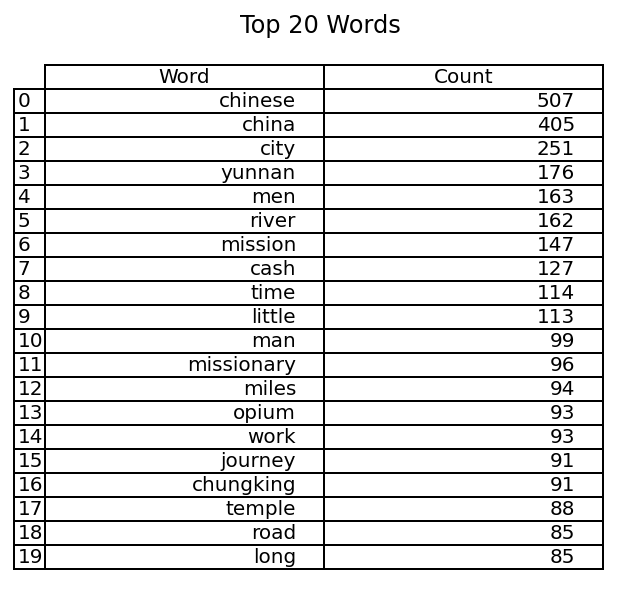

In [17]:
my_frame = df_3.head(20)
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)

ax.table(cellText = my_frame.values,
          rowLabels = my_frame.index,
          colLabels = my_frame.columns,
          loc = "center"
         )
ax.set_title("Top 20 Words ")

ax.axis("off");

Description:

So, I have never read this book before, but what strikes me of interest is that mission is used 147 times, missionary is used 96 times, and opium is used 93 times. Which tells me that this book takes place a little after the second opium war. And, since the story is supposed to be recounting someone time in China, I'm guessing they saw the impact of opium wars. 

In [18]:
#Topic Modeling, Thanks Jack!
def topical(content,n_topics,n_top_words):
    txt_1 = "".join(content).lower()
    txt_paragraphs = txt_1.split("\n\n")
    vectorizer = CountVectorizer(stop_words="english")
    X = vectorizer.fit_transform(txt_paragraphs)
    model = lda.LDA(n_topics, n_iter=1500, random_state=1)
    model.fit(X)
    vocab = vectorizer.get_feature_names()
    topic_word = model.topic_word_
    for i, topic_dist in enumerate(topic_word):
        topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
        print('Topic {}: {}'.format(i, ' '.join(topic_words)))
    return()

In [19]:
topical(content,20,10)

INFO:lda:n_documents: 1222


INFO:lda:vocab_size: 10046


INFO:lda:n_words: 43093


INFO:lda:n_topics: 20


INFO:lda:n_iter: 1500


INFO:lda:<0> log likelihood: -585460


INFO:lda:<10> log likelihood: -423334


INFO:lda:<20> log likelihood: -413359


INFO:lda:<30> log likelihood: -407552


INFO:lda:<40> log likelihood: -403971


INFO:lda:<50> log likelihood: -401480


INFO:lda:<60> log likelihood: -400605


INFO:lda:<70> log likelihood: -398982


INFO:lda:<80> log likelihood: -397875


INFO:lda:<90> log likelihood: -397123


INFO:lda:<100> log likelihood: -396418


INFO:lda:<110> log likelihood: -395760


INFO:lda:<120> log likelihood: -395235


INFO:lda:<130> log likelihood: -394964


INFO:lda:<140> log likelihood: -394211


INFO:lda:<150> log likelihood: -393800


INFO:lda:<160> log likelihood: -394033


INFO:lda:<170> log likelihood: -393586


INFO:lda:<180> log likelihood: -393486


INFO:lda:<190> log likelihood: -393160


INFO:lda:<200> log likelihood: -393043


INFO:lda:<210> log likelihood: -392540


INFO:lda:<220> log likelihood: -392788


INFO:lda:<230> log likelihood: -392845


INFO:lda:<240> log likelihood: -392479


INFO:lda:<250> log likelihood: -392868


INFO:lda:<260> log likelihood: -392463


INFO:lda:<270> log likelihood: -392762


INFO:lda:<280> log likelihood: -392580


INFO:lda:<290> log likelihood: -392096


INFO:lda:<300> log likelihood: -391870


INFO:lda:<310> log likelihood: -392269


INFO:lda:<320> log likelihood: -392451


INFO:lda:<330> log likelihood: -392250


INFO:lda:<340> log likelihood: -392510


INFO:lda:<350> log likelihood: -392085


INFO:lda:<360> log likelihood: -391846


INFO:lda:<370> log likelihood: -392431


INFO:lda:<380> log likelihood: -392124


INFO:lda:<390> log likelihood: -392735


INFO:lda:<400> log likelihood: -392019


INFO:lda:<410> log likelihood: -391730


INFO:lda:<420> log likelihood: -392158


INFO:lda:<430> log likelihood: -391937


INFO:lda:<440> log likelihood: -391579


INFO:lda:<450> log likelihood: -391693


INFO:lda:<460> log likelihood: -391147


INFO:lda:<470> log likelihood: -391891


INFO:lda:<480> log likelihood: -391929


INFO:lda:<490> log likelihood: -391430


INFO:lda:<500> log likelihood: -391774


INFO:lda:<510> log likelihood: -391940


INFO:lda:<520> log likelihood: -391704


INFO:lda:<530> log likelihood: -391601


INFO:lda:<540> log likelihood: -391470


INFO:lda:<550> log likelihood: -391317


INFO:lda:<560> log likelihood: -391989


INFO:lda:<570> log likelihood: -391638


INFO:lda:<580> log likelihood: -391558


INFO:lda:<590> log likelihood: -391931


INFO:lda:<600> log likelihood: -391436


INFO:lda:<610> log likelihood: -391354


INFO:lda:<620> log likelihood: -391802


INFO:lda:<630> log likelihood: -391182


INFO:lda:<640> log likelihood: -391797


INFO:lda:<650> log likelihood: -391590


INFO:lda:<660> log likelihood: -391403


INFO:lda:<670> log likelihood: -391055


INFO:lda:<680> log likelihood: -391208


INFO:lda:<690> log likelihood: -391535


INFO:lda:<700> log likelihood: -391166


INFO:lda:<710> log likelihood: -391791


INFO:lda:<720> log likelihood: -391799


INFO:lda:<730> log likelihood: -391121


INFO:lda:<740> log likelihood: -391225


INFO:lda:<750> log likelihood: -391325


INFO:lda:<760> log likelihood: -391922


INFO:lda:<770> log likelihood: -391804


INFO:lda:<780> log likelihood: -391421


INFO:lda:<790> log likelihood: -391705


INFO:lda:<800> log likelihood: -391509


INFO:lda:<810> log likelihood: -391466


INFO:lda:<820> log likelihood: -391289


INFO:lda:<830> log likelihood: -391193


INFO:lda:<840> log likelihood: -390978


INFO:lda:<850> log likelihood: -391428


INFO:lda:<860> log likelihood: -391489


INFO:lda:<870> log likelihood: -391259


INFO:lda:<880> log likelihood: -391254


INFO:lda:<890> log likelihood: -391438


INFO:lda:<900> log likelihood: -391279


INFO:lda:<910> log likelihood: -391784


INFO:lda:<920> log likelihood: -391422


INFO:lda:<930> log likelihood: -391167


INFO:lda:<940> log likelihood: -391258


INFO:lda:<950> log likelihood: -391162


INFO:lda:<960> log likelihood: -391497


INFO:lda:<970> log likelihood: -391251


INFO:lda:<980> log likelihood: -391848


INFO:lda:<990> log likelihood: -391531


INFO:lda:<1000> log likelihood: -391267


INFO:lda:<1010> log likelihood: -391538


INFO:lda:<1020> log likelihood: -391446


INFO:lda:<1030> log likelihood: -391241


INFO:lda:<1040> log likelihood: -391674


INFO:lda:<1050> log likelihood: -391355


INFO:lda:<1060> log likelihood: -390799


INFO:lda:<1070> log likelihood: -391406


INFO:lda:<1080> log likelihood: -391153


INFO:lda:<1090> log likelihood: -391385


INFO:lda:<1100> log likelihood: -391238


INFO:lda:<1110> log likelihood: -391335


INFO:lda:<1120> log likelihood: -391173


INFO:lda:<1130> log likelihood: -391095


INFO:lda:<1140> log likelihood: -391284


INFO:lda:<1150> log likelihood: -391067


INFO:lda:<1160> log likelihood: -391268


INFO:lda:<1170> log likelihood: -391355


INFO:lda:<1180> log likelihood: -391187


INFO:lda:<1190> log likelihood: -390652


INFO:lda:<1200> log likelihood: -391268


INFO:lda:<1210> log likelihood: -390689


INFO:lda:<1220> log likelihood: -391177


INFO:lda:<1230> log likelihood: -391290


INFO:lda:<1240> log likelihood: -390926


INFO:lda:<1250> log likelihood: -390747


INFO:lda:<1260> log likelihood: -390999


INFO:lda:<1270> log likelihood: -390956


INFO:lda:<1280> log likelihood: -390977


INFO:lda:<1290> log likelihood: -390717


INFO:lda:<1300> log likelihood: -390847


INFO:lda:<1310> log likelihood: -391193


INFO:lda:<1320> log likelihood: -391320


INFO:lda:<1330> log likelihood: -391312


INFO:lda:<1340> log likelihood: -391065


INFO:lda:<1350> log likelihood: -391109


INFO:lda:<1360> log likelihood: -391593


INFO:lda:<1370> log likelihood: -391371


INFO:lda:<1380> log likelihood: -391012


INFO:lda:<1390> log likelihood: -391280


INFO:lda:<1400> log likelihood: -391168


INFO:lda:<1410> log likelihood: -391196


INFO:lda:<1420> log likelihood: -391224


INFO:lda:<1430> log likelihood: -391105


INFO:lda:<1440> log likelihood: -390853


INFO:lda:<1450> log likelihood: -391390


INFO:lda:<1460> log likelihood: -390827


INFO:lda:<1470> log likelihood: -390626


INFO:lda:<1480> log likelihood: -391102


INFO:lda:<1490> log likelihood: -390886


INFO:lda:<1499> log likelihood: -390866


Topic 0: mission missionary missionaries china mr inland little time work years
Topic 1: men miles day days journey coolies way li long road
Topic 2: river road valley feet mountain bridge high town little plain
Topic 3: cash yunnan gold silver money capital 100 taels number cost
Topic 4: chinese said english foreign came room told words understand crowd
Topic 5: china chinese years known seen family sent love told far
Topic 6: death children dead wife living mother woman way husband girls
Topic 7: burma bhamo china burmese british journey soldiers men officer western
Topic 8: gutenberg project tm work works foundation terms electronic agreement states
Topic 9: opium china chinese shall pipe poppy chairen large grown eye
Topic 10: chinese china yunnan chungking yangtse telegraph customs mr provinces french
Topic 11: cited rev dr infanticide john university worship peking sir high
Topic 12: river boat water bank like men time junk rapid moment
Topic 13: room rice inn tea street poor lit

()

Description:

Here are twenty topics in ten words.And, I think that these topics help make sense of the top twenty words!

In [20]:
# Does this book portray China in a negative or postive light? Let's do a sentiment analysis

with open('texts-on-china/19172.txt', 'r') as f:
    content = f.readlines()


In [21]:
#I'm trying to see when the book actually starts
content[:257]

["Project Gutenberg's An Australian in China, by George Ernest Morrison\n",
 '\n',
 'This eBook is for the use of anyone anywhere at no cost and with\n',
 'almost no restrictions whatsoever.  You may copy it, give it away or\n',
 're-use it under the terms of the Project Gutenberg License included\n',
 'with this eBook or online at www.gutenberg.org\n',
 '\n',
 '\n',
 'Title: An Australian in China\n',
 '       Being the Narrative of a Quiet Journey Across China to Burma\n',
 '\n',
 'Author: George Ernest Morrison\n',
 '\n',
 'Release Date: September 4, 2006 [EBook #19172]\n',
 '\n',
 'Language: English\n',
 '\n',
 'Character set encoding: ASCII\n',
 '\n',
 '*** START OF THIS PROJECT GUTENBERG EBOOK AN AUSTRALIAN IN CHINA ***\n',
 '\n',
 '\n',
 '\n',
 '\n',
 'Produced by Thierry Alberto and the Online Distributed\n',
 'Proofreading Team at http://www.pgdp.net\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '       *       *       *       *       *\n',
 '    +-----------------------------------

In [22]:
#modify the content so that it starts with the actual text and not with the gutenberg stuff. 
edited_content = content[257:]

In [23]:
pattern = "\w[A-Z]+[.]"
edited_content = re.sub(pattern, "", " ".join(edited_content))

In [24]:
lines_list = tokenize.sent_tokenize(edited_content)

In [25]:
sid = SentimentIntensityAnalyzer()

for sentence in lines_list[40:70]:
     print(sentence)
     ss = sid.polarity_scores(sentence)
     for k in sorted(ss):
         print('{0}: {1}, '.format(k, ss[k]), end='')
     print()

He has iron and coal mines, with a railway seventeen
 miles long from the mines to the river, and specially constructed
 river-steamers and special hoisting machinery at the river-banks.
compound: 0.4019, neg: 0.0, neu: 0.909, pos: 0.091, 
Money
 he has poured out like water; he is probably the only important official
 in China who will leave office a poor man.
compound: -0.0, neg: 0.162, neu: 0.677, pos: 0.162, 
Acting as private secretary to the Viceroy is a clever Chinese named Kaw
 Hong Beng, the author of _Defensio Populi_, that often-quoted attack
 upon missionary methods which appeared first in _The North China Daily
 News_.
compound: -0.0258, neg: 0.081, neu: 0.84, pos: 0.079, 
A linguist of unusual ability, who publishes in _The Daily News_
 translations from Heine in English verse, Kaw is gifted with a rare
 command over the resources of English.
compound: 0.3182, neg: 0.0, neu: 0.919, pos: 0.081, 
He is a Master of Arts of the
 University of Edinburgh.
compound: 0.0, neg: 0.

Description:

So, its seems as though this book doesn't portray China in either a negative or positive light, but mostly neutral. Though, I am curious because it was published in 1895, if the sentiment analysis is picking up certain descriptions and accurately deciding whether its negative or positive, like I know this book uses Chinaman, which isn't positive. So, I'm curious if I could train the sentiment analysis function specifically for this time and if, I were to do so, would that change the values. 

# Closing Thoughts

I think I got more questions than answers with this project. And, I'm not sure if I could consider it done, like now I want to know what was happening in the 1920s for academia, how can I train a sentiment analysis for the 1880-1920s period, should I change my jstor data to all data, so that I can get a better picture of what people where talking about, and how would I do a close reading of these jstor documents? 

There's a lot to think about, but I think that this project has been very useful for me in learning some python! 